### Authors

* **Deepak Hazarika** 
* **Parinita Bora**
* **Gurudatta**

# Import Libraries

In [1]:
# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt


In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR


import logging
import sys
from datetime import datetime

now = datetime.now()

#sys.stdout = open('Run8_L1_L2_GBN_99_xx_logfile' + str(now) + '.log','a')

logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s',
                    filename='logfile.log',
                    filemode='a')

logging.info("Start " + str(now))
print("Start of logging V3 " + str(now))

Start of logging V3 2020-08-29 16:08:11.129622


## Params


In [3]:
BATCH_SIZE = 128
LR = 0.022
MODEL_VERSION = 2
LAMBDA_L1 = 0.0001
GBN_NUM_SPLITS = 2
NUM_WORKERS = 4 
LAMBDA_L1 = 0.0001
WEIGHT_DCY = 0.001

modelinfo =  "Model version- " + str( MODEL_VERSION) + ", Bacth size- " + str(BATCH_SIZE) + ", Learning rate- " + str(LR) 
modelinfo = modelinfo  + " L1 lambda_l1 " + str(LAMBDA_L1) + " L2  wt decay " + str(WEIGHT_DCY) + " Only GBN  w_o weight , GBN_NUM_SPLITS " + str(GBN_NUM_SPLITS) + " num of workers " + str(NUM_WORKERS)

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [4]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomAffine(degrees=10, translate=(0.1,0.1), scale=(0.9, 1.1)),
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [5]:
modelinfo = modelinfo + " Random affine 10 and Random color jitter 0.1 + relu in conv6 + gap at end" 
print(modelinfo)

Model version- 2, Bacth size- 128, Learning rate- 0.022 L1 lambda_l1 0.0001 L2  wt decay 0.001 Only GBN  w_o weight , GBN_NUM_SPLITS 2 num of workers 4 Random affine 10 and Random color jitter 0.1 + relu in conv6 + gap at end


In [6]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloader Arguments & Test/Train Dataloaders


In [7]:


SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True) if cuda else dict(shuffle=True, batch_size=BATCH_SIZE)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)



CUDA Available? True


# Ghost Batch Norm

In [9]:
class GhostBatchNorm(nn.BatchNorm2d):
    """
    From : https://github.com/davidcpage/cifar10-fast/blob/master/bag_of_tricks.ipynb

    Batch norm seems to work best with batch size of around 32. The reasons presumably have to do 
    with noise in the batch statistics and specifically a balance between a beneficial regularising effect 
    at intermediate batch sizes and an excess of noise at small batches.
    
    Our batches are of size 512 and we can't afford to reduce them without taking a serious hit on training times, 
    but we can apply batch norm separately to subsets of a training batch. This technique, known as 'ghost' batch 
    norm, is usually used in a distributed setting but is just as useful when using large batches on a single node. 
    It isn't supported directly in PyTorch but we can roll our own easily enough.
    """
    def __init__(self, num_features, num_splits, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super(GhostBatchNorm, self).__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias        
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features*self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features*self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(self.num_splits)
        return super(GhostBatchNorm, self).train(mode)
        
    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C*self.num_splits, H, W), self.running_mean, self.running_var, 
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W) 
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features], 
                self.weight, self.bias, False, self.momentum, self.eps)

    

# The model
 Model with Batch Normalization

In [10]:
class BNNet(nn.Module):
    def __init__(self):
        super(BNNet, self).__init__()
        # Input Block
        c_in = 1
        c_out = 8
        #print("running BN network")
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(c_out),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        c_in = 8
        c_out = 8
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(c_out),
            nn.ReLU()
        ) # output_size = 24
        
        c_in = 8
        c_out = 8
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(c_out),
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1

        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        
        c_in = 8
        c_out = 16
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(c_out),
            nn.ReLU()
        ) # output_size = 22

        # CONVOLUTION BLOCK 2
        c_in = 16
        c_out = 16
        
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(c_out),
            nn.ReLU()
        ) # output_size = 9
        c_in = 16
        c_out = 16
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(c_out),
            nn.ReLU()
        ) # output_size = 7

        c_in = 16
        c_out = 10
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, kernel_size=(1, 1), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # output_size = 1

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        
        x = self.convblock9(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

Model with Ghost Batch Normalization

In [11]:
class GBNNet(nn.Module):
    def __init__(self):
        super(GBNNet, self).__init__()
        # Input Block
        c_in = 1
        c_out = 8
        #print("running GBN network")
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, kernel_size=(3, 3), padding=0, bias=False),
            GhostBatchNorm(c_out, num_splits=GBN_NUM_SPLITS, weight=False),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        c_in = 8
        c_out = 8
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, kernel_size=(3, 3), padding=0, bias=False),
            GhostBatchNorm(c_out, num_splits=GBN_NUM_SPLITS, weight=False),
            nn.ReLU()
        ) # output_size = 24
        
        c_in = 8
        c_out = 8
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, kernel_size=(3, 3), padding=0, bias=False),
            GhostBatchNorm(c_out, num_splits=GBN_NUM_SPLITS, weight=False),
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1

        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        
        c_in = 8
        c_out = 16
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, kernel_size=(3, 3), padding=0, bias=False),
            GhostBatchNorm(c_out, num_splits=GBN_NUM_SPLITS, weight=False),
            nn.ReLU()
        ) # output_size = 22

        # CONVOLUTION BLOCK 2
        c_in = 16
        c_out = 16
        
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, kernel_size=(3, 3), padding=0, bias=False),
            GhostBatchNorm(c_out, num_splits=GBN_NUM_SPLITS, weight=False),
            nn.ReLU()
        ) # output_size = 9
        c_in = 16
        c_out = 16
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, kernel_size=(3, 3), padding=0, bias=False),
            GhostBatchNorm(c_out, num_splits=GBN_NUM_SPLITS, weight=False),
            nn.ReLU()
        ) # output_size = 7

        c_in = 16
        c_out = 10
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, kernel_size=(1, 1), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # output_size = 1

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        
        x = self.convblock9(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [12]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = BNNet().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
            Conv2d-4            [-1, 8, 24, 24]             576
       BatchNorm2d-5            [-1, 8, 24, 24]              16
              ReLU-6            [-1, 8, 24, 24]               0
            Conv2d-7            [-1, 8, 22, 22]             576
       BatchNorm2d-8            [-1, 8, 22, 22]              16
              ReLU-9            [-1, 8, 22, 22]               0
        MaxPool2d-10            [-1, 8, 11, 11]               0
           Conv2d-11             [-1, 16, 9, 9]           1,152
      BatchNorm2d-12             [-1, 16, 9, 9]              32
             ReLU-13             [-1, 16, 9, 9]               0
           Conv2d-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [14]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch , use_L1 = False):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    ## l1 regularization
    if (use_L1):
      #print( " use L1 ")
      l1 = 0
      for p in model.parameters():
        l1 += p.abs().sum()
      loss += LAMBDA_L1*l1
    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
  print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        loss.item(), correct, processed ,
        100. * correct / processed))
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# runModel definition

In [15]:
def runModel(runNum):
  use_L1 = False
  use_L2 = False

  l_one_list = [1,3,5]  
  l_two_list = [2,3,5]
  gbn_list = [4,5]
  

  if runNum in l_one_list:
    use_L1 = True

  if runNum in l_two_list:
    use_L2 = True

  if runNum in gbn_list :
    train_gbn = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
    test_gbn = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)
    SEED = 1

    # CUDA?
    cuda = torch.cuda.is_available()
    print("CUDA Available?", cuda)

    # For reproducibility
    torch.manual_seed(SEED)

    if cuda:
      torch.cuda.manual_seed(SEED)

    # dataloader arguments - something you'll fetch these from cmdprmt
    dataloader_args_gbn = dict(shuffle=True, batch_size=BATCH_SIZE*2, num_workers=NUM_WORKERS, pin_memory=True) if cuda else dict(shuffle=True, batch_size=BATCH_SIZE*2)

    # train dataloader
    train_loader_gbn = torch.utils.data.DataLoader(train_gbn, **dataloader_args_gbn)

    # test dataloader
    test_loader_gbn = torch.utils.data.DataLoader(test_gbn, **dataloader_args_gbn)

  if (runNum < 4):
    model =  BNNet().to(device)
  else:
    model =  GBNNet().to(device)


  if (use_L2):
    #print ("use L2 ")
    optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9 , weight_decay= WEIGHT_DCY , nesterov = False)
  else:
    optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)

  scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
  #print ("use L1 ", use_L1 , " use L2 ", use_L2)


  EPOCHS = 25

  if (runNum < 4):
    for epoch in range(EPOCHS):
        print("EPOCH:", epoch)
        train(model, device, train_loader, optimizer, epoch , use_L1)
        test(model, device, test_loader)
        scheduler.step()
    
  else:
    for epoch in range(EPOCHS):
        print("EPOCH:", epoch)
        train(model, device, train_loader_gbn, optimizer, epoch , use_L1)
        test(model, device, test_loader_gbn)
        scheduler.step()
    



      

# Let's Train and test our model

In [16]:
for i in range(5):
  runModel(i+1)
  torch.cuda.empty_cache()


  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.23036174476146698 Batch_id=468 Accuracy=85.58: 100%|██████████| 469/469 [00:49<00:00,  9.48it/s]


Train set: Average loss: 0.2304, Accuracy: 51347/60000 (85.58%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0628, Accuracy: 9807/10000 (98.07%)

EPOCH: 1


Loss=0.13013148307800293 Batch_id=468 Accuracy=96.76: 100%|██████████| 469/469 [00:49<00:00,  9.42it/s]


Train set: Average loss: 0.1301, Accuracy: 58055/60000 (96.76%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0711, Accuracy: 9798/10000 (97.98%)

EPOCH: 2


Loss=0.123867467045784 Batch_id=468 Accuracy=97.41: 100%|██████████| 469/469 [00:49<00:00,  9.55it/s]


Train set: Average loss: 0.1239, Accuracy: 58444/60000 (97.41%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0447, Accuracy: 9857/10000 (98.57%)

EPOCH: 3


Loss=0.08871044218540192 Batch_id=468 Accuracy=97.78: 100%|██████████| 469/469 [00:49<00:00,  9.44it/s]



Train set: Average loss: 0.0887, Accuracy: 58669/60000 (97.78%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0308, Accuracy: 9904/10000 (99.04%)

EPOCH: 4


Loss=0.1796131134033203 Batch_id=468 Accuracy=97.73: 100%|██████████| 469/469 [00:49<00:00,  9.54it/s]



Train set: Average loss: 0.1796, Accuracy: 58637/60000 (97.73%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0369, Accuracy: 9883/10000 (98.83%)

EPOCH: 5


Loss=0.1966993510723114 Batch_id=468 Accuracy=97.89: 100%|██████████| 469/469 [00:48<00:00,  9.65it/s]


Train set: Average loss: 0.1967, Accuracy: 58737/60000 (97.89%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9914/10000 (99.14%)

EPOCH: 6


Loss=0.07327835261821747 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:48<00:00,  9.67it/s]


Train set: Average loss: 0.0733, Accuracy: 59145/60000 (98.58%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9947/10000 (99.47%)

EPOCH: 7


Loss=0.11368191242218018 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:48<00:00,  9.62it/s]


Train set: Average loss: 0.1137, Accuracy: 59202/60000 (98.67%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9947/10000 (99.47%)

EPOCH: 8


Loss=0.07647646963596344 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:49<00:00,  9.56it/s]


Train set: Average loss: 0.0765, Accuracy: 59222/60000 (98.70%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9948/10000 (99.48%)

EPOCH: 9


Loss=0.0827331691980362 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:49<00:00,  9.52it/s]


Train set: Average loss: 0.0827, Accuracy: 59242/60000 (98.74%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9952/10000 (99.52%)

EPOCH: 10


Loss=0.13387209177017212 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:49<00:00,  9.50it/s]


Train set: Average loss: 0.1339, Accuracy: 59227/60000 (98.71%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9946/10000 (99.46%)

EPOCH: 11


Loss=0.14585773646831512 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:49<00:00,  9.49it/s]


Train set: Average loss: 0.1459, Accuracy: 59268/60000 (98.78%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9942/10000 (99.42%)

EPOCH: 12


Loss=0.08187324553728104 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:49<00:00,  9.52it/s]


Train set: Average loss: 0.0819, Accuracy: 59264/60000 (98.77%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9949/10000 (99.49%)

EPOCH: 13


Loss=0.1400311291217804 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:49<00:00,  9.41it/s]


Train set: Average loss: 0.1400, Accuracy: 59281/60000 (98.80%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9945/10000 (99.45%)

EPOCH: 14


Loss=0.15772628784179688 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:49<00:00,  9.52it/s]


Train set: Average loss: 0.1577, Accuracy: 59250/60000 (98.75%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9949/10000 (99.49%)

EPOCH: 15


Loss=0.07771802693605423 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:48<00:00,  9.59it/s]


Train set: Average loss: 0.0777, Accuracy: 59293/60000 (98.82%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9949/10000 (99.49%)

EPOCH: 16


Loss=0.09153515845537186 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:49<00:00,  9.56it/s]


Train set: Average loss: 0.0915, Accuracy: 59294/60000 (98.82%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9946/10000 (99.46%)

EPOCH: 17


Loss=0.08118866384029388 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:49<00:00,  9.54it/s]


Train set: Average loss: 0.0812, Accuracy: 59277/60000 (98.80%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9950/10000 (99.50%)

EPOCH: 18


Loss=0.08537289500236511 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:48<00:00,  9.72it/s]



Train set: Average loss: 0.0854, Accuracy: 59324/60000 (98.87%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9951/10000 (99.51%)

EPOCH: 19


Loss=0.11807765811681747 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:48<00:00,  9.76it/s]


Train set: Average loss: 0.1181, Accuracy: 59343/60000 (98.91%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9948/10000 (99.48%)

EPOCH: 20


Loss=0.10286872088909149 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:51<00:00,  9.13it/s]


Train set: Average loss: 0.1029, Accuracy: 59269/60000 (98.78%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9947/10000 (99.47%)

EPOCH: 21


Loss=0.13818085193634033 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:51<00:00,  9.12it/s]


Train set: Average loss: 0.1382, Accuracy: 59313/60000 (98.86%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9948/10000 (99.48%)

EPOCH: 22


Loss=0.0878944844007492 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:51<00:00,  9.08it/s]


Train set: Average loss: 0.0879, Accuracy: 59288/60000 (98.81%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9950/10000 (99.50%)

EPOCH: 23


Loss=0.14492623507976532 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:51<00:00,  9.17it/s]


Train set: Average loss: 0.1449, Accuracy: 59281/60000 (98.80%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9947/10000 (99.47%)

EPOCH: 24


Loss=0.0732463076710701 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:51<00:00,  9.06it/s]


Train set: Average loss: 0.0732, Accuracy: 59363/60000 (98.94%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9947/10000 (99.47%)

EPOCH: 0


Loss=0.25263577699661255 Batch_id=468 Accuracy=84.67: 100%|██████████| 469/469 [00:50<00:00,  9.33it/s]


Train set: Average loss: 0.2526, Accuracy: 50799/60000 (84.67%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0842, Accuracy: 9776/10000 (97.76%)

EPOCH: 1


Loss=0.07457343488931656 Batch_id=468 Accuracy=96.83: 100%|██████████| 469/469 [00:51<00:00,  9.16it/s]


Train set: Average loss: 0.0746, Accuracy: 58097/60000 (96.83%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0773, Accuracy: 9739/10000 (97.39%)

EPOCH: 2


Loss=0.08882836252450943 Batch_id=468 Accuracy=97.42: 100%|██████████| 469/469 [00:51<00:00,  9.15it/s]


Train set: Average loss: 0.0888, Accuracy: 58454/60000 (97.42%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0372, Accuracy: 9898/10000 (98.98%)

EPOCH: 3


Loss=0.047775495797395706 Batch_id=468 Accuracy=97.80: 100%|██████████| 469/469 [00:51<00:00,  9.17it/s]


Train set: Average loss: 0.0478, Accuracy: 58679/60000 (97.80%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0338, Accuracy: 9912/10000 (99.12%)

EPOCH: 4


Loss=0.07200346142053604 Batch_id=468 Accuracy=97.80: 100%|██████████| 469/469 [00:51<00:00,  9.14it/s]


Train set: Average loss: 0.0720, Accuracy: 58682/60000 (97.80%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0346, Accuracy: 9887/10000 (98.87%)

EPOCH: 5


Loss=0.09915438294410706 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:51<00:00,  9.15it/s]


Train set: Average loss: 0.0992, Accuracy: 58786/60000 (97.98%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0380, Accuracy: 9897/10000 (98.97%)

EPOCH: 6


Loss=0.08391960710287094 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:51<00:00,  9.17it/s]


Train set: Average loss: 0.0839, Accuracy: 59088/60000 (98.48%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9946/10000 (99.46%)

EPOCH: 7


Loss=0.057507406920194626 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:51<00:00,  9.14it/s]


Train set: Average loss: 0.0575, Accuracy: 59138/60000 (98.56%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9943/10000 (99.43%)

EPOCH: 8


Loss=0.03044614940881729 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:51<00:00,  9.16it/s]


Train set: Average loss: 0.0304, Accuracy: 59150/60000 (98.58%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9949/10000 (99.49%)

EPOCH: 9


Loss=0.03663330897688866 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:51<00:00,  9.14it/s]


Train set: Average loss: 0.0366, Accuracy: 59208/60000 (98.68%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9938/10000 (99.38%)

EPOCH: 10


Loss=0.03754587844014168 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:50<00:00,  9.33it/s]


Train set: Average loss: 0.0375, Accuracy: 59209/60000 (98.68%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9935/10000 (99.35%)

EPOCH: 11


Loss=0.07896574586629868 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:49<00:00,  9.45it/s]


Train set: Average loss: 0.0790, Accuracy: 59215/60000 (98.69%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9941/10000 (99.41%)

EPOCH: 12


Loss=0.016151929274201393 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:49<00:00,  9.43it/s]


Train set: Average loss: 0.0162, Accuracy: 59248/60000 (98.75%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9952/10000 (99.52%)

EPOCH: 13


Loss=0.049011241644620895 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:48<00:00,  9.57it/s]


Train set: Average loss: 0.0490, Accuracy: 59253/60000 (98.75%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9950/10000 (99.50%)

EPOCH: 14


Loss=0.06087833270430565 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:48<00:00,  9.64it/s]


Train set: Average loss: 0.0609, Accuracy: 59253/60000 (98.75%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9944/10000 (99.44%)

EPOCH: 15


Loss=0.08371267467737198 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:49<00:00,  9.48it/s]


Train set: Average loss: 0.0837, Accuracy: 59240/60000 (98.73%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9946/10000 (99.46%)

EPOCH: 16


Loss=0.059265006333589554 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:48<00:00,  9.65it/s]


Train set: Average loss: 0.0593, Accuracy: 59259/60000 (98.77%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9947/10000 (99.47%)

EPOCH: 17


Loss=0.022429345175623894 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:48<00:00,  9.68it/s]


Train set: Average loss: 0.0224, Accuracy: 59266/60000 (98.78%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9945/10000 (99.45%)

EPOCH: 18


Loss=0.06107361242175102 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:47<00:00,  9.80it/s]


Train set: Average loss: 0.0611, Accuracy: 59252/60000 (98.75%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9950/10000 (99.50%)

EPOCH: 19


Loss=0.08629002422094345 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:49<00:00,  9.50it/s]


Train set: Average loss: 0.0863, Accuracy: 59198/60000 (98.66%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9950/10000 (99.50%)

EPOCH: 20


Loss=0.022834492847323418 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:50<00:00,  9.34it/s]


Train set: Average loss: 0.0228, Accuracy: 59254/60000 (98.76%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9949/10000 (99.49%)

EPOCH: 21


Loss=0.04126746580004692 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:49<00:00,  9.40it/s]


Train set: Average loss: 0.0413, Accuracy: 59255/60000 (98.76%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9941/10000 (99.41%)

EPOCH: 22


Loss=0.03376956656575203 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:49<00:00,  9.46it/s]


Train set: Average loss: 0.0338, Accuracy: 59248/60000 (98.75%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9945/10000 (99.45%)

EPOCH: 23


Loss=0.061476390808820724 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:48<00:00,  9.60it/s]



Train set: Average loss: 0.0615, Accuracy: 59266/60000 (98.78%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9949/10000 (99.49%)

EPOCH: 24


Loss=0.02944241464138031 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:49<00:00,  9.40it/s]


Train set: Average loss: 0.0294, Accuracy: 59231/60000 (98.72%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9948/10000 (99.48%)

EPOCH: 0


Loss=0.2873671352863312 Batch_id=468 Accuracy=86.64: 100%|██████████| 469/469 [00:51<00:00,  9.11it/s]


Train set: Average loss: 0.2874, Accuracy: 51986/60000 (86.64%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0631, Accuracy: 9833/10000 (98.33%)

EPOCH: 1


Loss=0.11309653520584106 Batch_id=468 Accuracy=96.74: 100%|██████████| 469/469 [00:51<00:00,  9.14it/s]


Train set: Average loss: 0.1131, Accuracy: 58044/60000 (96.74%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0690, Accuracy: 9798/10000 (97.98%)

EPOCH: 2


Loss=0.08025769144296646 Batch_id=468 Accuracy=97.27: 100%|██████████| 469/469 [00:52<00:00,  8.99it/s]


Train set: Average loss: 0.0803, Accuracy: 58363/60000 (97.27%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0436, Accuracy: 9876/10000 (98.76%)

EPOCH: 3


Loss=0.1810270994901657 Batch_id=468 Accuracy=97.41: 100%|██████████| 469/469 [00:51<00:00,  9.08it/s]


Train set: Average loss: 0.1810, Accuracy: 58445/60000 (97.41%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0379, Accuracy: 9882/10000 (98.82%)

EPOCH: 4


Loss=0.12740856409072876 Batch_id=468 Accuracy=97.47: 100%|██████████| 469/469 [00:51<00:00,  9.10it/s]


Train set: Average loss: 0.1274, Accuracy: 58482/60000 (97.47%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0678, Accuracy: 9790/10000 (97.90%)

EPOCH: 5


Loss=0.1102142333984375 Batch_id=468 Accuracy=97.60: 100%|██████████| 469/469 [00:51<00:00,  9.10it/s]


Train set: Average loss: 0.1102, Accuracy: 58562/60000 (97.60%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0602, Accuracy: 9825/10000 (98.25%)

EPOCH: 6


Loss=0.11308620870113373 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:51<00:00,  9.10it/s]


Train set: Average loss: 0.1131, Accuracy: 58997/60000 (98.33%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9930/10000 (99.30%)

EPOCH: 7


Loss=0.11813851445913315 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:51<00:00,  9.16it/s]


Train set: Average loss: 0.1181, Accuracy: 59090/60000 (98.48%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9928/10000 (99.28%)

EPOCH: 8


Loss=0.12802603840827942 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:50<00:00,  9.20it/s]


Train set: Average loss: 0.1280, Accuracy: 59092/60000 (98.49%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9928/10000 (99.28%)

EPOCH: 9


Loss=0.07249406725168228 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:50<00:00,  9.27it/s]


Train set: Average loss: 0.0725, Accuracy: 59114/60000 (98.52%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9929/10000 (99.29%)

EPOCH: 10


Loss=0.12317605316638947 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:50<00:00,  9.38it/s]


Train set: Average loss: 0.1232, Accuracy: 59152/60000 (98.59%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9928/10000 (99.28%)

EPOCH: 11


Loss=0.06894771754741669 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:49<00:00,  9.43it/s]


Train set: Average loss: 0.0689, Accuracy: 59184/60000 (98.64%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9926/10000 (99.26%)

EPOCH: 12


Loss=0.10945242643356323 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:50<00:00,  9.22it/s]


Train set: Average loss: 0.1095, Accuracy: 59183/60000 (98.64%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9930/10000 (99.30%)

EPOCH: 13


Loss=0.07341154664754868 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:51<00:00,  9.17it/s]


Train set: Average loss: 0.0734, Accuracy: 59228/60000 (98.71%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9926/10000 (99.26%)

EPOCH: 14


Loss=0.08894803375005722 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:51<00:00,  9.08it/s]


Train set: Average loss: 0.0889, Accuracy: 59198/60000 (98.66%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9931/10000 (99.31%)

EPOCH: 15


Loss=0.06082063168287277 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:50<00:00,  9.34it/s]


Train set: Average loss: 0.0608, Accuracy: 59215/60000 (98.69%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9930/10000 (99.30%)

EPOCH: 16


Loss=0.07079662382602692 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:50<00:00,  9.36it/s]


Train set: Average loss: 0.0708, Accuracy: 59252/60000 (98.75%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9933/10000 (99.33%)

EPOCH: 17


Loss=0.06169690191745758 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:49<00:00,  9.40it/s]


Train set: Average loss: 0.0617, Accuracy: 59227/60000 (98.71%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9932/10000 (99.32%)

EPOCH: 18


Loss=0.10403898358345032 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:50<00:00,  9.31it/s]


Train set: Average loss: 0.1040, Accuracy: 59257/60000 (98.76%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9930/10000 (99.30%)

EPOCH: 19


Loss=0.08816879987716675 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:50<00:00,  9.25it/s]


Train set: Average loss: 0.0882, Accuracy: 59237/60000 (98.73%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9930/10000 (99.30%)

EPOCH: 20


Loss=0.05838802456855774 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:49<00:00,  9.46it/s]


Train set: Average loss: 0.0584, Accuracy: 59242/60000 (98.74%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9929/10000 (99.29%)

EPOCH: 21


Loss=0.09797913581132889 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:49<00:00,  9.43it/s]


Train set: Average loss: 0.0980, Accuracy: 59251/60000 (98.75%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9933/10000 (99.33%)

EPOCH: 22


Loss=0.06601083278656006 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:49<00:00,  9.41it/s]


Train set: Average loss: 0.0660, Accuracy: 59199/60000 (98.67%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9933/10000 (99.33%)

EPOCH: 23


Loss=0.0779619961977005 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:49<00:00,  9.38it/s]


Train set: Average loss: 0.0780, Accuracy: 59258/60000 (98.76%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9928/10000 (99.28%)

EPOCH: 24


Loss=0.12715087831020355 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:50<00:00,  9.31it/s]


Train set: Average loss: 0.1272, Accuracy: 59245/60000 (98.74%)




  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9933/10000 (99.33%)

CUDA Available? True
EPOCH: 0


Loss=0.2941690981388092 Batch_id=234 Accuracy=78.53: 100%|██████████| 235/235 [00:44<00:00,  5.30it/s]


Train set: Average loss: 0.2942, Accuracy: 47121/60000 (78.53%)




  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.2135, Accuracy: 9474/10000 (94.74%)

EPOCH: 1


Loss=0.13804271817207336 Batch_id=234 Accuracy=95.93: 100%|██████████| 235/235 [00:45<00:00,  5.22it/s]


Train set: Average loss: 0.1380, Accuracy: 57560/60000 (95.93%)




  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.1037, Accuracy: 9721/10000 (97.21%)

EPOCH: 2


Loss=0.04245281592011452 Batch_id=234 Accuracy=96.79: 100%|██████████| 235/235 [00:44<00:00,  5.25it/s]



Train set: Average loss: 0.0425, Accuracy: 58072/60000 (96.79%)



  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0690, Accuracy: 9801/10000 (98.01%)

EPOCH: 3


Loss=0.05472773686051369 Batch_id=234 Accuracy=97.28: 100%|██████████| 235/235 [00:45<00:00,  5.22it/s]


Train set: Average loss: 0.0547, Accuracy: 58366/60000 (97.28%)




  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0534, Accuracy: 9840/10000 (98.40%)

EPOCH: 4


Loss=0.06693261116743088 Batch_id=234 Accuracy=97.53: 100%|██████████| 235/235 [00:44<00:00,  5.26it/s]


Train set: Average loss: 0.0669, Accuracy: 58519/60000 (97.53%)




  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0585, Accuracy: 9830/10000 (98.30%)

EPOCH: 5


Loss=0.07331841439008713 Batch_id=234 Accuracy=97.66: 100%|██████████| 235/235 [00:44<00:00,  5.33it/s]


Train set: Average loss: 0.0733, Accuracy: 58595/60000 (97.66%)




  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0348, Accuracy: 9903/10000 (99.03%)

EPOCH: 6


Loss=0.0425165630877018 Batch_id=234 Accuracy=98.21: 100%|██████████| 235/235 [00:44<00:00,  5.28it/s]


Train set: Average loss: 0.0425, Accuracy: 58926/60000 (98.21%)




  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Accuracy: 9932/10000 (99.32%)

EPOCH: 7


Loss=0.12016981840133667 Batch_id=234 Accuracy=98.25: 100%|██████████| 235/235 [00:44<00:00,  5.27it/s]


Train set: Average loss: 0.1202, Accuracy: 58952/60000 (98.25%)




  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 9923/10000 (99.23%)

EPOCH: 8


Loss=0.12893682718276978 Batch_id=234 Accuracy=98.20: 100%|██████████| 235/235 [00:44<00:00,  5.28it/s]


Train set: Average loss: 0.1289, Accuracy: 58923/60000 (98.20%)




  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9932/10000 (99.32%)

EPOCH: 9


Loss=0.019441641867160797 Batch_id=234 Accuracy=98.30: 100%|██████████| 235/235 [00:44<00:00,  5.23it/s]


Train set: Average loss: 0.0194, Accuracy: 58979/60000 (98.30%)




  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9930/10000 (99.30%)

EPOCH: 10


Loss=0.09407702088356018 Batch_id=234 Accuracy=98.37: 100%|██████████| 235/235 [00:45<00:00,  5.21it/s]


Train set: Average loss: 0.0941, Accuracy: 59021/60000 (98.37%)




  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9934/10000 (99.34%)

EPOCH: 11


Loss=0.13120409846305847 Batch_id=234 Accuracy=98.25: 100%|██████████| 235/235 [00:45<00:00,  5.18it/s]


Train set: Average loss: 0.1312, Accuracy: 58951/60000 (98.25%)




  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9927/10000 (99.27%)

EPOCH: 12


Loss=0.037958573549985886 Batch_id=234 Accuracy=98.42: 100%|██████████| 235/235 [00:44<00:00,  5.29it/s]


Train set: Average loss: 0.0380, Accuracy: 59054/60000 (98.42%)




  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9935/10000 (99.35%)

EPOCH: 13


Loss=0.08683023601770401 Batch_id=234 Accuracy=98.38: 100%|██████████| 235/235 [00:45<00:00,  5.19it/s]


Train set: Average loss: 0.0868, Accuracy: 59025/60000 (98.38%)




  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9932/10000 (99.32%)

EPOCH: 14


Loss=0.04100999981164932 Batch_id=234 Accuracy=98.42: 100%|██████████| 235/235 [00:45<00:00,  5.15it/s]


Train set: Average loss: 0.0410, Accuracy: 59050/60000 (98.42%)




  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9930/10000 (99.30%)

EPOCH: 15


Loss=0.05674881115555763 Batch_id=234 Accuracy=98.40: 100%|██████████| 235/235 [00:45<00:00,  5.13it/s]


Train set: Average loss: 0.0567, Accuracy: 59039/60000 (98.40%)




  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9929/10000 (99.29%)

EPOCH: 16


Loss=0.055898696184158325 Batch_id=234 Accuracy=98.42: 100%|██████████| 235/235 [00:45<00:00,  5.19it/s]


Train set: Average loss: 0.0559, Accuracy: 59050/60000 (98.42%)




  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9935/10000 (99.35%)

EPOCH: 17


Loss=0.03835487738251686 Batch_id=234 Accuracy=98.42: 100%|██████████| 235/235 [00:46<00:00,  5.08it/s]


Train set: Average loss: 0.0384, Accuracy: 59052/60000 (98.42%)




  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9931/10000 (99.31%)

EPOCH: 18


Loss=0.10622809082269669 Batch_id=234 Accuracy=98.43: 100%|██████████| 235/235 [00:46<00:00,  5.10it/s]


Train set: Average loss: 0.1062, Accuracy: 59057/60000 (98.43%)




  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9930/10000 (99.30%)

EPOCH: 19


Loss=0.06969226151704788 Batch_id=234 Accuracy=98.44: 100%|██████████| 235/235 [00:46<00:00,  5.08it/s]


Train set: Average loss: 0.0697, Accuracy: 59065/60000 (98.44%)




  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9930/10000 (99.30%)

EPOCH: 20


Loss=0.05250329151749611 Batch_id=234 Accuracy=98.46: 100%|██████████| 235/235 [00:45<00:00,  5.19it/s]


Train set: Average loss: 0.0525, Accuracy: 59075/60000 (98.46%)




  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9932/10000 (99.32%)

EPOCH: 21


Loss=0.12157853692770004 Batch_id=234 Accuracy=98.39: 100%|██████████| 235/235 [00:46<00:00,  5.09it/s]


Train set: Average loss: 0.1216, Accuracy: 59033/60000 (98.39%)




  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9930/10000 (99.30%)

EPOCH: 22


Loss=0.020987018942832947 Batch_id=234 Accuracy=98.42: 100%|██████████| 235/235 [00:46<00:00,  5.07it/s]


Train set: Average loss: 0.0210, Accuracy: 59054/60000 (98.42%)




  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9930/10000 (99.30%)

EPOCH: 23


Loss=0.0336671881377697 Batch_id=234 Accuracy=98.36: 100%|██████████| 235/235 [00:47<00:00,  4.95it/s]


Train set: Average loss: 0.0337, Accuracy: 59017/60000 (98.36%)




  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9929/10000 (99.29%)

EPOCH: 24


Loss=0.053347136825323105 Batch_id=234 Accuracy=98.46: 100%|██████████| 235/235 [00:47<00:00,  4.96it/s]


Train set: Average loss: 0.0533, Accuracy: 59075/60000 (98.46%)




  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9931/10000 (99.31%)

CUDA Available? True
EPOCH: 0


Loss=0.3442864716053009 Batch_id=234 Accuracy=78.60: 100%|██████████| 235/235 [00:47<00:00,  4.93it/s]


Train set: Average loss: 0.3443, Accuracy: 47158/60000 (78.60%)




  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.2911, Accuracy: 9218/10000 (92.18%)

EPOCH: 1


Loss=0.18672847747802734 Batch_id=234 Accuracy=96.02: 100%|██████████| 235/235 [00:46<00:00,  5.04it/s]


Train set: Average loss: 0.1867, Accuracy: 57612/60000 (96.02%)




  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0960, Accuracy: 9763/10000 (97.63%)

EPOCH: 2


Loss=0.11176450550556183 Batch_id=234 Accuracy=96.90: 100%|██████████| 235/235 [00:46<00:00,  5.04it/s]


Train set: Average loss: 0.1118, Accuracy: 58142/60000 (96.90%)




  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.1151, Accuracy: 9703/10000 (97.03%)

EPOCH: 3


Loss=0.10386741161346436 Batch_id=234 Accuracy=97.27: 100%|██████████| 235/235 [00:46<00:00,  5.10it/s]


Train set: Average loss: 0.1039, Accuracy: 58363/60000 (97.27%)




  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0487, Accuracy: 9873/10000 (98.73%)

EPOCH: 4


Loss=0.1549897938966751 Batch_id=234 Accuracy=97.50: 100%|██████████| 235/235 [00:46<00:00,  5.02it/s]


Train set: Average loss: 0.1550, Accuracy: 58501/60000 (97.50%)




  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0532, Accuracy: 9866/10000 (98.66%)

EPOCH: 5


Loss=0.15893998742103577 Batch_id=234 Accuracy=97.60: 100%|██████████| 235/235 [00:46<00:00,  5.01it/s]



Train set: Average loss: 0.1589, Accuracy: 58558/60000 (97.60%)



  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0639, Accuracy: 9835/10000 (98.35%)

EPOCH: 6


Loss=0.0943080335855484 Batch_id=234 Accuracy=98.17: 100%|██████████| 235/235 [00:47<00:00,  4.92it/s]


Train set: Average loss: 0.0943, Accuracy: 58905/60000 (98.17%)




  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0295, Accuracy: 9923/10000 (99.23%)

EPOCH: 7


Loss=0.14616680145263672 Batch_id=234 Accuracy=98.31: 100%|██████████| 235/235 [00:48<00:00,  4.88it/s]


Train set: Average loss: 0.1462, Accuracy: 58984/60000 (98.31%)




  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9927/10000 (99.27%)

EPOCH: 8


Loss=0.15547068417072296 Batch_id=234 Accuracy=98.33: 100%|██████████| 235/235 [00:47<00:00,  4.97it/s]


Train set: Average loss: 0.1555, Accuracy: 58996/60000 (98.33%)




  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9921/10000 (99.21%)

EPOCH: 9


Loss=0.07531163096427917 Batch_id=234 Accuracy=98.37: 100%|██████████| 235/235 [00:46<00:00,  5.03it/s]


Train set: Average loss: 0.0753, Accuracy: 59022/60000 (98.37%)




  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0276, Accuracy: 9929/10000 (99.29%)

EPOCH: 10


Loss=0.14603623747825623 Batch_id=234 Accuracy=98.43: 100%|██████████| 235/235 [00:47<00:00,  4.97it/s]


Train set: Average loss: 0.1460, Accuracy: 59059/60000 (98.43%)




  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Accuracy: 9927/10000 (99.27%)

EPOCH: 11


Loss=0.18987171351909637 Batch_id=234 Accuracy=98.33: 100%|██████████| 235/235 [00:47<00:00,  4.94it/s]


Train set: Average loss: 0.1899, Accuracy: 58998/60000 (98.33%)




  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Accuracy: 9921/10000 (99.21%)

EPOCH: 12


Loss=0.09017425030469894 Batch_id=234 Accuracy=98.53: 100%|██████████| 235/235 [00:47<00:00,  4.90it/s]


Train set: Average loss: 0.0902, Accuracy: 59115/60000 (98.53%)




  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9930/10000 (99.30%)

EPOCH: 13


Loss=0.13038064539432526 Batch_id=234 Accuracy=98.48: 100%|██████████| 235/235 [00:47<00:00,  4.96it/s]


Train set: Average loss: 0.1304, Accuracy: 59090/60000 (98.48%)




  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 9928/10000 (99.28%)

EPOCH: 14


Loss=0.10372193157672882 Batch_id=234 Accuracy=98.52: 100%|██████████| 235/235 [00:46<00:00,  5.05it/s]



Train set: Average loss: 0.1037, Accuracy: 59112/60000 (98.52%)



  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9932/10000 (99.32%)

EPOCH: 15


Loss=0.11252588033676147 Batch_id=234 Accuracy=98.53: 100%|██████████| 235/235 [00:47<00:00,  5.00it/s]


Train set: Average loss: 0.1125, Accuracy: 59120/60000 (98.53%)




  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9927/10000 (99.27%)

EPOCH: 16


Loss=0.09872201085090637 Batch_id=234 Accuracy=98.43: 100%|██████████| 235/235 [00:47<00:00,  4.96it/s]


Train set: Average loss: 0.0987, Accuracy: 59060/60000 (98.43%)




  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 9931/10000 (99.31%)

EPOCH: 17


Loss=0.08921119570732117 Batch_id=234 Accuracy=98.51: 100%|██████████| 235/235 [00:47<00:00,  4.97it/s]


Train set: Average loss: 0.0892, Accuracy: 59108/60000 (98.51%)




  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Accuracy: 9929/10000 (99.29%)

EPOCH: 18


Loss=0.14113983511924744 Batch_id=234 Accuracy=98.47: 100%|██████████| 235/235 [00:46<00:00,  5.02it/s]


Train set: Average loss: 0.1411, Accuracy: 59081/60000 (98.47%)




  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0266, Accuracy: 9928/10000 (99.28%)

EPOCH: 19


Loss=0.12089446932077408 Batch_id=234 Accuracy=98.48: 100%|██████████| 235/235 [00:46<00:00,  5.04it/s]


Train set: Average loss: 0.1209, Accuracy: 59091/60000 (98.48%)




  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9928/10000 (99.28%)

EPOCH: 20


Loss=0.11536774039268494 Batch_id=234 Accuracy=98.50: 100%|██████████| 235/235 [00:46<00:00,  5.10it/s]


Train set: Average loss: 0.1154, Accuracy: 59099/60000 (98.50%)




  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Accuracy: 9930/10000 (99.30%)

EPOCH: 21


Loss=0.1409156620502472 Batch_id=234 Accuracy=98.46: 100%|██████████| 235/235 [00:46<00:00,  5.00it/s]


Train set: Average loss: 0.1409, Accuracy: 59078/60000 (98.46%)




  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9933/10000 (99.33%)

EPOCH: 22


Loss=0.07627982646226883 Batch_id=234 Accuracy=98.52: 100%|██████████| 235/235 [00:46<00:00,  5.02it/s]


Train set: Average loss: 0.0763, Accuracy: 59110/60000 (98.52%)




  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9931/10000 (99.31%)

EPOCH: 23


Loss=0.0779697373509407 Batch_id=234 Accuracy=98.44: 100%|██████████| 235/235 [00:46<00:00,  5.06it/s]


Train set: Average loss: 0.0780, Accuracy: 59061/60000 (98.44%)




  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9934/10000 (99.34%)

EPOCH: 24


Loss=0.09482008963823318 Batch_id=234 Accuracy=98.55: 100%|██████████| 235/235 [00:46<00:00,  5.01it/s]



Train set: Average loss: 0.0948, Accuracy: 59131/60000 (98.55%)


Test set: Average loss: 0.0264, Accuracy: 9932/10000 (99.32%)



In [17]:
trainlosses = []
for i in range(len(train_losses)):
  trainlosses.append(float(train_losses[i].cpu().detach().numpy()))
  


In [18]:
len(trainlosses)//5

9385

# Plot accuracy and loss 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: Second argument 'y1' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: Second argument 'y2' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: Second argument 'y3' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the forma

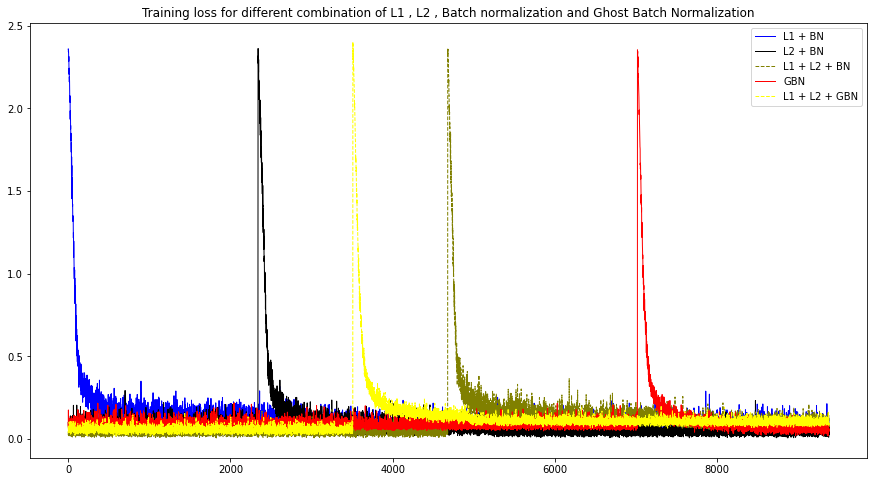

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

loss_interval =  len(trainlosses)//5
# Data

df=pd.DataFrame({'x': range(loss_interval),
                 'y01': trainlosses[0:loss_interval] ,
                 'y1': trainlosses[loss_interval:(2*loss_interval)] ,
                 'y2': trainlosses[2*loss_interval:(3*loss_interval)] , 
                 'y3': trainlosses[3*loss_interval:(4*loss_interval)] , 
                 'y4': trainlosses[4*loss_interval:(5*loss_interval)] })

# multiple line plot
plt.figure(figsize=(15,8))
plt.plot( 'x', 'y01', data=df, marker='',  color='blue', linewidth=1 , label='L1 + BN') #markerfacecolor='blue', markersize=12,
plt.plot( 'x', 'y1', data=df, marker='', color='black', linewidth=1 , label='L2 + BN')
plt.plot( 'x', 'y2', data=df, marker='', color='olive', linewidth=1, linestyle='dashed', label="L1 + L2 + BN")
plt.plot( 'x', 'y3', data=df, marker='', color='red', linewidth=1 , label='GBN')
plt.plot( 'x', 'y4', data=df, marker='', color='yellow', linewidth=1, linestyle='dashed', label="L1 + L2 + GBN")
plt.title("Training loss for different combination of L1 , L2 , Batch normalization and Ghost Batch Normalization")
plt.legend()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: Second argument 'y1' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Second argument 'y2' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Second argument 'y3' is ambiguous: could be a format string but is in 'data'; using as data

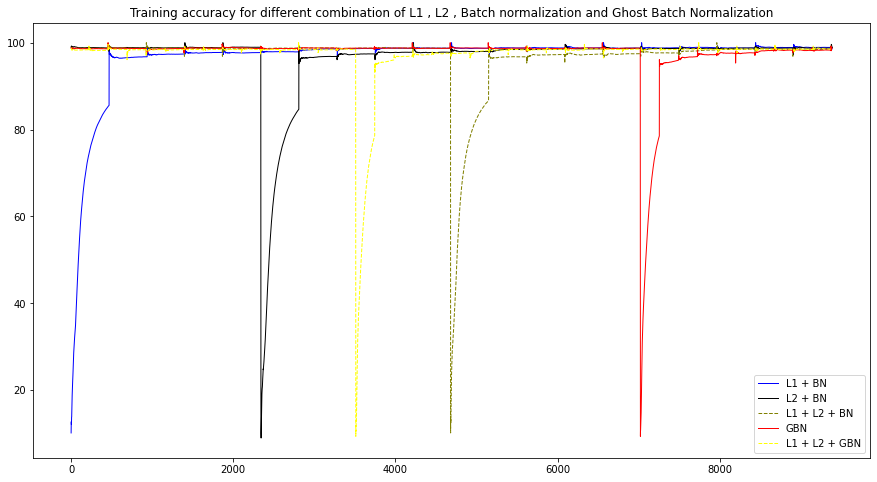

In [20]:
loss_interval =  len(train_acc)//5
# Data

df=pd.DataFrame({'x': range(loss_interval),
                 'y0': train_acc[0:loss_interval] ,
                 'y1': train_acc[loss_interval:(2*loss_interval)] ,
                 'y2': train_acc[2*loss_interval:(3*loss_interval)] , 
                 'y3': train_acc[3*loss_interval:(4*loss_interval)] , 
                 'y4': train_acc[4*loss_interval:(5*loss_interval)] })

# multiple line plot
plt.figure(figsize=(15,8))
plt.plot( 'x', 'y0', data=df, marker='',  color='blue', linewidth=1 , label='L1 + BN') #markerfacecolor='blue', markersize=12,
plt.plot( 'x', 'y1', data=df, marker='', color='black', linewidth=1 , label='L2 + BN')
plt.plot( 'x', 'y2', data=df, marker='', color='olive', linewidth=1, linestyle='dashed', label="L1 + L2 + BN")
plt.plot( 'x', 'y3', data=df, marker='', color='red', linewidth=1 , label='GBN')
plt.plot( 'x', 'y4', data=df, marker='', color='yellow', linewidth=1, linestyle='dashed', label="L1 + L2 + GBN")
plt.title("Training accuracy for different combination of L1 , L2 , Batch normalization and Ghost Batch Normalization")
plt.legend()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: Second argument 'y1' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Second argument 'y2' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Second argument 'y3' is ambiguous: could be a format string but is in 'data'; using as data

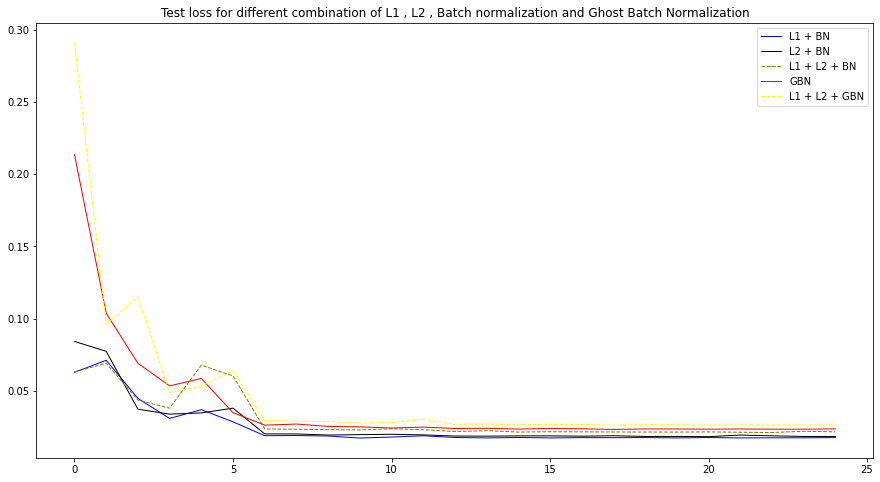

In [21]:
loss_interval =  len(test_losses)//5
# Data

df=pd.DataFrame({'x': range(loss_interval),
                 'y0': test_losses[0:loss_interval] ,
                 'y1': test_losses[loss_interval:(2*loss_interval)] ,
                 'y2': test_losses[2*loss_interval:(3*loss_interval)] , 
                 'y3': test_losses[3*loss_interval:(4*loss_interval)] , 
                 'y4': test_losses[4*loss_interval:(5*loss_interval)] })

# multiple line plot
plt.figure(figsize=(15,8))
plt.plot( 'x', 'y0', data=df, marker='',  color='blue', linewidth=1 , label='L1 + BN') #markerfacecolor='blue', markersize=12,
plt.plot( 'x', 'y1', data=df, marker='', color='black', linewidth=1 , label='L2 + BN')
plt.plot( 'x', 'y2', data=df, marker='', color='olive', linewidth=1, linestyle='dashed', label="L1 + L2 + BN")
plt.plot( 'x', 'y3', data=df, marker='', color='red', linewidth=1 , label='GBN')
plt.plot( 'x', 'y4', data=df, marker='', color='yellow', linewidth=1, linestyle='dashed', label="L1 + L2 + GBN")
plt.title("Test loss for different combination of L1 , L2 , Batch normalization and Ghost Batch Normalization")
plt.legend()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: Second argument 'y1' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Second argument 'y2' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Second argument 'y3' is ambiguous: could be a format string but is in 'data'; using as data

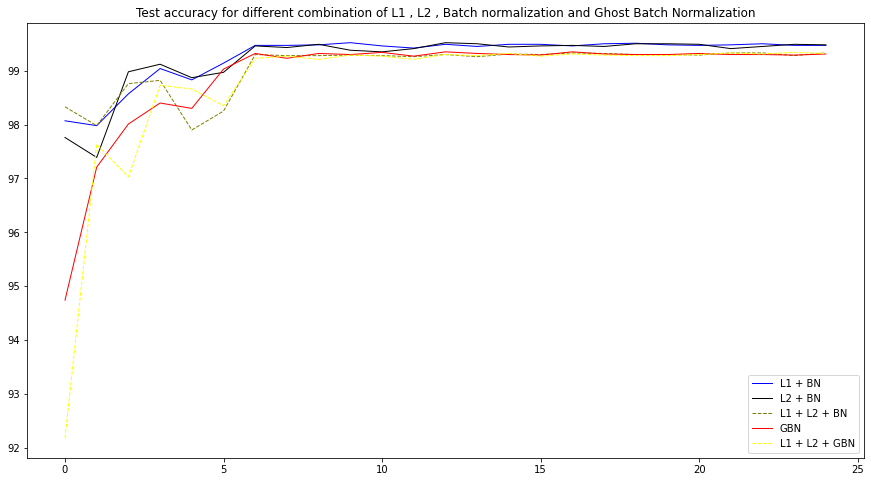

In [22]:
loss_interval =  len(test_acc)//5
# Data

df=pd.DataFrame({'x': range(loss_interval),
                 'y0': test_acc[0:loss_interval] ,
                 'y1': test_acc[loss_interval:(2*loss_interval)] ,
                 'y2': test_acc[2*loss_interval:(3*loss_interval)] , 
                 'y3': test_acc[3*loss_interval:(4*loss_interval)] , 
                 'y4': test_acc[4*loss_interval:(5*loss_interval)] })

# multiple line plot
plt.figure(figsize=(15,8))
plt.plot( 'x', 'y0', data=df, marker='',  color='blue', linewidth=1 , label='L1 + BN') #markerfacecolor='blue', markersize=12,
plt.plot( 'x', 'y1', data=df, marker='', color='black', linewidth=1 , label='L2 + BN')
plt.plot( 'x', 'y2', data=df, marker='', color='olive', linewidth=1, linestyle='dashed', label="L1 + L2 + BN")
plt.plot( 'x', 'y3', data=df, marker='', color='red', linewidth=1 , label='GBN')
plt.plot( 'x', 'y4', data=df, marker='', color='yellow', linewidth=1, linestyle='dashed', label="L1 + L2 + GBN")
plt.title("Test accuracy for different combination of L1 , L2 , Batch normalization and Ghost Batch Normalization")
plt.legend()

# Misclassified image

In [23]:
# code used from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html?highlight=predict
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.squeeze(0)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


In [24]:
# code used from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html?highlight=predict
def visualize_model(model, num_images=26):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(26,26))

    with torch.no_grad():
        for data, target in test_loader:
            inputs , labels = data.to(device), target.to(device)
            """output = model(data)

        for i, (inputs, labels) in test_loader['val']:
            inputs = inputs.to(device)
            labels = labels.to(device)"""

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
              if (preds[j] != labels[j]):
                fig = plt.figure(figsize=(30,30))
                images_so_far += 1
                ax = plt.subplot(num_images//13, 13, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {} actual: {}'.format(preds[j],labels[j]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

<Figure size 1872x1872 with 0 Axes>

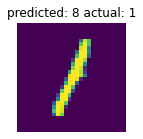

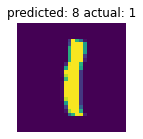

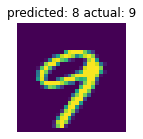

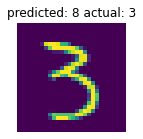

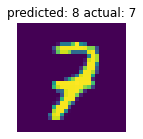

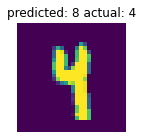

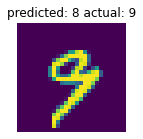

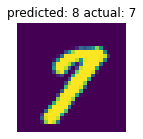

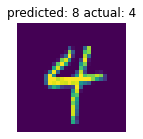

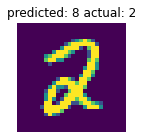

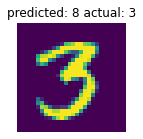

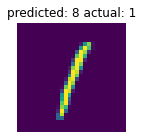

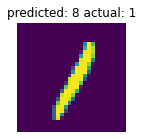

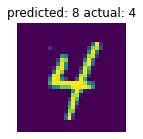

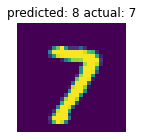

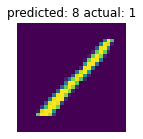

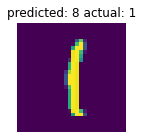

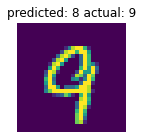

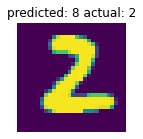

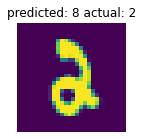

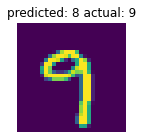

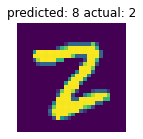

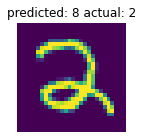

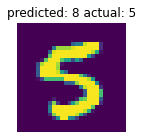

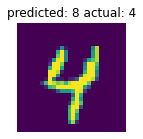

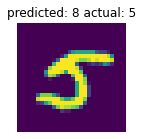

In [25]:
visualize_model(model)

In [26]:
now = datetime.now()

print("End of logging V2" + str(now))

End of logging V22020-08-29 17:54:12.502028
